In [787]:
using local_POD_overlap.module_2D

using LinearAlgebra
using Plots
using LaTeXStrings
using ProgressBars

import LinearAlgebra.eigvals 
using Statistics
using Random
using Distributions
using SparseArrays
using JLD

In [788]:
function overlap_shifter(data,overlap_MP;index = 3,forward = true)


    shift_x, shift_y = Int.(round.(1/2 .* overlap_MP.J))

    if forward
        shifted_x = circshift( data,(shift_x,0))
        shifted_y = circshift( data,(0,shift_y))
        shifted_x_y = circshift( data,(shift_x,shift_y))
    else
        shifted_x = circshift( data,(-shift_x,0))
        shifted_y = circshift( data,(0,-shift_y))
        shifted_x_y = circshift( data,(-shift_x,-shift_y))


    end
    
    indexes = collect(1:size(data)[index])
    shifted_indexes_x = indexes .+ size(data)[index]
    shifted_indexes_y = indexes .+ 2*size(data)[index]
    shifted_indexes_x_y = indexes .+ 3*size(data)[index]

    indexes = cat(indexes,shifted_indexes_x,shifted_indexes_y,shifted_indexes_x_y,dims = 2)'[1:end]
    
    modes = cat(data,shifted_x,shifted_y,shifted_x_y,dims = index)
    
    return modes[[(:) for i in 1:index-1]...,indexes,[(:) for i in 1:(length(size(modes))-index)]...]
end

function carry_out_local_SVD_overlap_2D_periodic_only(input,MP)

    UPC = MP.fine_mesh.UPC
    dims = MP.fine_mesh.dims
    
    overlap_fine_mesh = MP.fine_mesh
    overlap_coarse_mesh = gen_coarse_from_fine_mesh(fine_mesh, 2 .* MP.J)
    overlap_MP = gen_mesh_pair(overlap_fine_mesh,overlap_coarse_mesh)
    
    kernel_x= collect(LinRange(-1,1,overlap_MP.J[1]+1))
    kernel_y = collect(LinRange(-1,1,overlap_MP.J[2]+1))

    kernel_mesh = gen_mesh(kernel_x,kernel_y,UPC = UPC,use_GPU = false)
    kernel = kernel_mesh.eval_function(mollifier_bump_kernel)

    input =  overlap_shifter(input,overlap_MP,index = 4)
    reshaped_input = kernel .* reshape_for_local_SVD(input,overlap_MP,subtract_average = false)
    

    vector_input = reshape(reshaped_input,(prod(size(reshaped_input)[1:end-1]),size(reshaped_input)[end]))

    SVD = svd(vector_input)

    return  reshape(SVD.U,(overlap_MP.J...,UPC,Int(size(SVD.U)[end]))),SVD.S,overlap_MP
end




    


function bilinear_kernel(x)

    m1 = (x[1] .< 0) .* (x[2] .< 0)
    
    m2 = (x[1] .>= 0) .* (x[2] .< 0)
    m3 = (x[1] .< 0) .* (x[2] .>= 0) 
    m4 = (x[1] .>= 0) .* (x[2] .>= 0)

    
    x1,y1 = x[1] .+ 1, x[2] .+ 1
    x2,y2 = x[1] , x[2] .+ 1
    x3,y3 = x[1] .+ 1, x[2] 
    x4,y4 = x[1] , x[2] 

    

    

    

    f1 = (x1 ) .* (y1)
    f2 = (1 .- x2 ) .* ( y2 )
    f3 = (x3 ) .* (1 .- y3  )
    f4 = (1 .- x4) .* (1 .- y4)


    return m1 .* f1 .+ m2 .* f2 .+ m3 .* f3 .+ m4 .* f4
    #return m3
end


function mollifier_bump_kernel(x)

    m1 = (x[1] .< 0) .* (x[2] .< 0)
    
    m2 = (x[1] .>= 0) .* (x[2] .< 0)
    m3 = (x[1] .< 0) .* (x[2] .>= 0) 
    m4 = (x[1] .>= 0) .* (x[2] .>= 0)


    x1,y1 = x[1] .+ 1, x[2] .+ 1
    x2,y2 = x[1] , x[2] .+ 1
    x3,y3 = x[1] .+ 1, x[2] 
    x4,y4 = x[1] , x[2] 

    delta = 1e-10
    ## circumvent the NaN at x = 0
    x1,y1 = max.(x1,delta), max.(y1,delta)
    x2,y2 = max.(x2,delta), max.(y2,delta)
    x3,y3 = max.(x3,delta), max.(y3,delta)
    x4,y4 = max.(x4,delta), max.(y4,delta)

    
    eta(x) = exp.(-(x)/(x*(1-x)))

    eta_tilde(x) = eta(x)/(eta(x)+eta(1-x))
    a(x) = eta_tilde(x)
    b(x) = 1 -a(x)
    
    f1 = b.(x1) .* b.(y1)
    f2 = a.(x2) .* b.(y2)
    f3 = b.(x3) .* a.(y3)
    f4 = a.(x4) .* a.(y4)


    return m1 .* f1 .+ m2 .* f2 .+ m3 .* f3 .+ m4 .* f4
    #return m3
end




struct overlap_projection_operators_struct
    Phi_T
    Phi
    S_inv
    S
    inv_S
end

function generate_ROM_operator(input_dimension,proj_FOM_rhs)

    dummy_vec = zeros(input_dimension)

    
    
    ROM_operator = zeros((input_dimension...,input_dimension...))

    for i in 1:input_dimension[1]
        test_vec = copy(dummy_vec)
        test_vec[i] += 1

        
        result = proj_FOM_rhs(test_vec)
        #output = reshape(,shape_2)

        ROM_operator[:,i] .+= result

    end
    
    return ROM_operator
end

function sparsify_matrix(A,tolerance = 1e-16)
    B = spzeros(size(A))
    for i in 1:size(A)[1]
        for j in 1:size(A)[2]
            if abs(A[i,j]) >= tolerance
                B[i,j] += A[i,j]
            end
        end
    end
    return B
end

function generate_S(overlap_MP,Phi_T,Phi)

    dummy_input = zeros(overlap_MP.fine_mesh.N...,1,1)
    dummy_vec = 0 * Phi_T(dummy_input)

    shape_1 = size(dummy_vec)
    shape_2 = (prod(shape_1),)

    dummy_vec = reshape(dummy_vec,shape_2)
    
    
    S = zeros((shape_2[1],shape_2[1]))

    for i in 1:shape_2[1]
        test_vec = copy(dummy_vec)
        test_vec[i] += 1

        test_vec = reshape(test_vec,shape_1)

        corresponding_state = Phi(test_vec)
        corresponding_coefficients = Phi_T(corresponding_state)
        overlap = reshape(corresponding_coefficients,shape_2)
        
        #output = reshape(,shape_2)

        S[:,i] .+= overlap

    end
    
    return S
end


function generate_S_2(overlap_MP,Phi_T,Phi)

    dummy_input = zeros(overlap_MP.fine_mesh.N...,1,1)
    dummy_vec = 0 * Phi_T(dummy_input)

    shape_1 = size(dummy_vec)
    q = shape_1[3]
    shape_2 = (prod(shape_1),)

    #dummy_vec = reshape(dummy_vec,shape_2)
    
    
    S = zeros((shape_2[1],shape_2[1]))

    inner_products = zeros((shape_2[1],q))
    
    for i in 1:q
        test_vec = copy(dummy_vec)
        test_vec[1,1,i,1] = 1
        corresponding_state = Phi(test_vec)
        corresponding_coefficients = Phi_T(corresponding_state)
        coefficients = reshape(corresponding_coefficients,shape_2)
        inner_products[:,i] = coefficients
    end

    counter = 1
    for i in 1:q
        coefficients = reshape(inner_products[:,i],shape_1)
        for y in 0:shape_1[2]-1
            for x in 0:shape_1[1]-1
                shifted_coeffs = circshift(coefficients,(x,y,0,0))
                S[:,counter] = reshape(shifted_coeffs,shape_2)
                counter += 1
            end
        end
    end

    
    

    
    return S#rand(Normal(0,1),size(S))
end





function gen_projection_operators_overlap_2D_periodic_only(overlap_modes,overlap_MP)
    PO = gen_projection_operators(overlap_modes,overlap_MP)
    
    function Phi_T(input,PO = PO,overlap_MP = overlap_MP)
        


        dims = overlap_MP.fine_mesh.dims
        shift_x, shift_y = Int.(round.(1/2 .* overlap_MP.J))

        output_1 = PO.Phi_T(input)
        output_2 = PO.Phi_T(circshift(input,(shift_x,0)))
        output_3 = PO.Phi_T(circshift(input,(0,shift_y)))
        output_4 = PO.Phi_T(circshift(input,(shift_x,shift_y)))

        indexes = collect(1:size(output_1)[dims+1])
        shifted_indexes_x = indexes .+ size(output_1)[dims+1]
        shifted_indexes_y = indexes .+ 2*size(output_1)[dims+1]
        shifted_indexes_x_y = indexes .+ 3*size(output_1)[dims+1]
    
        indexes = cat(indexes,shifted_indexes_x,shifted_indexes_y,shifted_indexes_x_y,dims = 2)'[1:end]
    
        
        output = cat(output_1,output_2,output_3,output_4,dims = dims + 1)

        return output[:,:,indexes,:]
        return input
    end

    function Phi(input,PO = PO,overlap_MP = overlap_MP)

        dims = overlap_MP.fine_mesh.dims
        
        shift_x, shift_y = Int.(round.(1/2 .* overlap_MP.J))
        
        number_of_modes = size(input)[dims+1]
        unique_modes = Int(round(number_of_modes/4))
        index_1 = 4 * collect(0:unique_modes-1) .+ 1 
        index_2 = index_1 .+ 1
        index_3 = index_1 .+ 2
        index_4 = index_1 .+ 3


        output_1 = PO.Phi(input[:,:,index_1,:]) 
        output_2 = circshift(PO.Phi(input[:,:,index_2,:]),(-shift_x,0) )
        output_3 = circshift(PO.Phi(input[:,:,index_3,:]),(0,-shift_y)) 
        output_4 = circshift(PO.Phi(input[:,:,index_4,:]),(-shift_x,-shift_y)) 
        
       
        return output_1 .+ output_2 .+ output_3 .+ output_4
    end

    S = generate_S_2(overlap_MP,Phi_T,Phi)
    inv_S = inv(Matrix(S))
    
    function S_inv(input,S = S, inv_S = inv_S)

        shape_1 = size(input)
        shape_2 = (prod(shape_1[1:end-1]),shape_1[end])

        reshaped_input = reshape(input,shape_2)
        solved = inv_S * reshaped_input
        #solved = solve(S,reshaped_input)
        output = reshape(solved,shape_1)
        
        
        return output


    end 

    
    return overlap_projection_operators_struct(Phi_T,Phi,S_inv,S,inv_S)
end


function proj_FOM(a,PO,rhs,fine_mesh)
    new_shape = size(PO.Phi_T(fine_mesh.omega))
    num_inputs = Int(round(prod(size(a))/prod(new_shape)))
    
    old_shape = prod(size(a))
    new_shape = (new_shape[1:end-1]...,num_inputs)

    c_r = PO.Phi(reshape(a,new_shape))
    rhs_c = rhs(c_r,fine_mesh,0)
    rhs_a = PO.Phi_T(rhs_c)
    

    
    rhs_a = reshape(rhs_a,old_shape)
    return rhs_a
end



proj_FOM (generic function with 1 method)

In [789]:
d = load("velocity_snapshots_128.jld")

Dict{String, Any} with 5 entries:
  "Vbar"     => Float32[-0.315589 -0.321426 … -0.288537 -0.305187; -0.299408 -0…
  "t"        => Float32[9.984;;;;; 9.988;;;;; 9.992;;;;; 9.996;;;;; 10.0]
  "dVbar_dt" => Float32[-0.180107 -0.145962 … -0.323721 -0.252854; -0.111893 -0…
  "E"        => [18.2065;;;;; 18.2055;;;;; 18.2045;;;;; 18.2035;;;;; 18.2025]
  "F"        => Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0…

In [790]:
N = (128,128)
UPC = 1       
use_GPU = false

x= collect(LinRange(-pi,pi,N[1]+1))
y = collect(LinRange(-pi,pi,N[2]+1))

fine_mesh = gen_mesh(x,y,UPC = UPC,use_GPU = use_GPU)
velocity_mesh = gen_mesh(x,y,UPC = fine_mesh.dims,use_GPU = use_GPU)
setup = gen_setup(velocity_mesh)
0

0

In [791]:
u_f(x) = x[1].^0 # .+ 100 * sin.(x[2]) .* cos.(x[1])
v_f(x) = x[2].^0 # .+ 100 * sin.(x[1]) .* cos.(x[2])

#u_f(x) =  sin.(x[2]) .* cos.(x[1])
#v_f(x) = -sin.(x[1]) .* cos.(x[2])


u = velocity_mesh.eval_function(u_f)
v = velocity_mesh.eval_function(v_f)

V = cat(u,v,dims = 3)[:,:,:,:]
V =  d["Vbar"][:,:,:,1:1,1] # .+ 1
V = project_divergence(V,setup)
w = setup.O.w(V)
setup.O.M(V)
0

0

In [792]:
c0_f_1(x) = exp.(-5*((x[1] .+ 1/2*pi).^2 .+ (x[2].+ 1/2*pi).^2))

c0_f_2(x) = -exp.(-5*((x[1] .- 1/2*pi).^2 .+ (x[2].- 1/2*pi).^2))


c0_f(x) = c0_f_1(x) + c0_f_2(x) #+ c0_f_3(x) + c0_f_4(x)
#c0_f(x) = sin.(x[1])
#q0_f(x) = sin.(5* x[1] ) +  cos.(4*x[2]) + 0.5 *cos.(7* x[1] )
c0 = fine_mesh.eval_function(c0_f)
#q0 =gen_random_field(fine_mesh.N,10, samples = (1,1))

128×128×1×1 Array{Float64, 4}:
[:, :, 1, 1] =
 4.1349e-11    8.72708e-11   1.79808e-10  …   9.50146e-53   0.0
 8.72708e-11   1.84193e-10   3.795e-10        0.0          -9.50146e-53
 1.79808e-10   3.795e-10     7.81899e-10     -1.93139e-51  -1.11086e-51
 3.61645e-10   7.63284e-10   1.57263e-9      -2.20431e-50  -1.08378e-50
 7.10056e-10   1.49864e-9    3.0877e-9       -2.09938e-49  -1.00242e-49
 1.36094e-9    2.87238e-9    5.91807e-9   …  -1.89555e-48  -8.99596e-49
 2.54635e-9    5.3743e-9     1.10729e-8      -1.66061e-47  -7.87078e-48
 4.65087e-9    9.81607e-9    2.02244e-8      -1.41832e-46  -6.72052e-47
 8.29249e-9    1.7502e-8     3.60602e-8      -1.18221e-45  -5.60141e-46
 1.44335e-8    3.04632e-8    6.27646e-8      -9.61888e-45  -4.55746e-45
 2.45241e-8    5.17604e-8    1.06644e-7   …  -7.63985e-44  -3.61977e-44
 4.06772e-8    8.58529e-8    1.76886e-7      -5.92351e-43  -2.80657e-43
 6.58634e-8    1.3901e-7     2.86409e-7      -4.48341e-42  -2.12425e-42
 ⋮                        

In [804]:
viscosity = 0.001
rhs = gen_rhs_advection_equation(setup,V = V,viscosity = viscosity,F = 0*c0)
t,  res = simulate(c0,fine_mesh,0.02,0,10,rhs,save_every = 5,pre_allocate = true)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


([0.1;;;;; 0.19999999999999998;;;;; 0.3;;;;; … ;;;;; 9.79999999999988;;;;; 9.899999999999878;;;;; 9.999999999999876], [1.5498373264182058e-10 3.1285006557551793e-10 … 1.694157259146678e-11 4.795662054071938e-11; 3.2939005658492264e-10 6.575599170031267e-10 … 1.9307463709159848e-11 1.026876811138777e-10; … ; 1.4781146353189573e-11 1.1611101403755095e-11 … -7.236777932219235e-11 -2.427710340507657e-11; 4.2452033681798046e-11 7.852056418548395e-11 … -2.2734718749525884e-11 2.483642916693337e-12;;;;; 5.384812700065577e-10 1.1169164722410446e-9 … 7.519678753231672e-11 2.2355113108303263e-10; 1.2104939804159285e-9 2.534501515650982e-9 … 1.7403983833786753e-10 5.190185412473624e-10; … ; 5.7283869261404156e-11 1.0515605170002365e-10 … -1.7109575899559278e-11 1.613059387203604e-11; 1.934810081373118e-10 3.9735183266535276e-10 … 1.9674277039289666e-11 7.625991085742536e-11;;;;; 1.974178413067616e-9 4.258463003233937e-9 … 3.459139669674075e-10 8.790843154935053e-10; 4.816508934716391e-9 1.0528981

In [805]:
training_data = res[:,:,:,1,1:50]
validation_data = res[:,:,:,1,61:80]
#test_data = res[:,:,:,1,51:100]
data = res[:,:,:,1,:]

128×128×1×100 Array{Float64, 4}:
[:, :, 1, 1] =
  1.54984e-10   3.1285e-10    6.5337e-10   …   1.69416e-11   4.79566e-11
  3.2939e-10    6.5756e-10    1.38141e-9       1.93075e-11   1.02688e-10
  7.21857e-10   1.44543e-9    3.05115e-9       5.33234e-11   2.42367e-10
  1.53637e-9    3.08285e-9    6.52428e-9       1.30974e-10   5.46115e-10
  3.17389e-9    6.36559e-9    1.34619e-8       3.06235e-10   1.18357e-9
  6.32992e-9    1.2637e-8     2.66214e-8   …   6.79971e-10   2.46117e-9
  1.21486e-8    2.40404e-8    5.03212e-8       1.43321e-9    4.90088e-9
  2.24656e-8    4.38955e-8    9.10944e-8       2.87769e-9    9.36487e-9
  4.02855e-8    7.74127e-8    1.58796e-7       5.57101e-9    1.73208e-8
  7.08684e-8    1.33334e-7    2.69051e-7       1.05996e-8    3.14832e-8
  1.23981e-7    2.27913e-7    4.49776e-7   …   1.98834e-8    5.68525e-8
  2.15203e-7    3.90878e-7    7.54665e-7       3.54475e-8    1.00032e-7
  3.59468e-7    6.59079e-7    1.26637e-6       5.80286e-8    1.65394e-7
  ⋮         

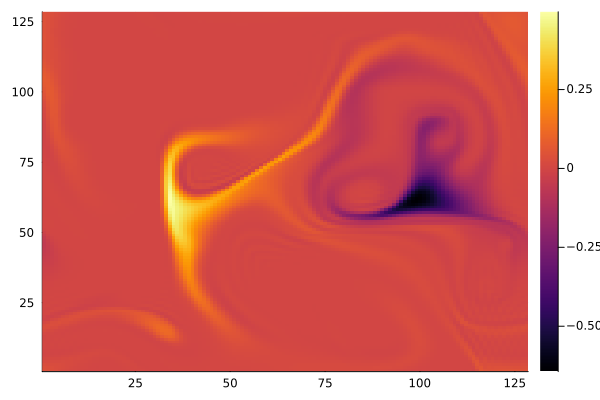

In [806]:
heatmap(data[:,:,1,end])

# Convergence test

In [808]:
function compute_L2(a_pred,a_ref;average = true)
    if average
        return mean(sqrt.(sum((a_pred-a_ref).^2,dims = [1,2])) ./ sqrt.(sum((a_ref).^2,dims = [1,2])))
    else
        return sqrt.(sum((a_pred-a_ref).^2,dims = [1,2])) ./ sqrt.(sum((a_ref).^2,dims = [1,2]))
    end
end

r_max = 5000
Is = [1,8,16,32]
#Is = [8,16,32]
#Is = [1]
local_errors_training = Dict()
overlap_errors_training = Dict()

local_errors_validation = Dict()
overlap_errors_validation = Dict()

for I in Is

    J = Int.(round.((1/I) .* fine_mesh.N)) # compression in each direction

    coarse_mesh = gen_coarse_from_fine_mesh(fine_mesh,J)
    MP = gen_mesh_pair(fine_mesh,coarse_mesh)


    local_errors_training[(I,J[1])] = []
    overlap_errors_training[(I,J[1])] = []

    local_errors_validation[(I,J[1])] = []
    overlap_errors_validation[(I,J[1])] = []

    
    modes,S = carry_out_local_SVD(training_data,MP)

    if I > 1
        overlap_modes,overlap_S,overlap_MP = carry_out_local_SVD_overlap_2D_periodic_only(training_data,MP)
    end

    qs = collect(Int.(collect(1:1:minimum([I^2 * size(training_data)[end],r_max/(I^2)]))))
    print(qs)
    for q in qs
        
        local_PO = gen_projection_operators(modes[:,:,:,1:q],MP)
        
        local_a = local_PO.Phi_T(training_data)
        local_c_r = local_PO.Phi(local_a)
    
        local_error = compute_L2(local_c_r,training_data)
        

        push!(local_errors_training[(I,J[1])],local_error)


        local_a = local_PO.Phi_T(validation_data)
        local_c_r = local_PO.Phi(local_a)

        local_error = compute_L2(local_c_r,validation_data)

        push!(local_errors_validation[(I,J[1])],local_error)
        
        

        ## Compute overlap error
        if I > 1
            overlap_PO = gen_projection_operators_overlap_2D_periodic_only(overlap_modes[:,:,:,1:q],overlap_MP)
            overlap_a = overlap_PO.Phi_T(training_data)
            solved = overlap_PO.S_inv(overlap_a)
            overlap_c_r = overlap_PO.Phi(solved)
    
            overlap_error = compute_L2(overlap_c_r,training_data)
    
            push!(overlap_errors_training[(I,J[1])],overlap_error)
                
            overlap_a = overlap_PO.Phi_T(validation_data)
            solved = overlap_PO.S_inv(overlap_a)
            overlap_c_r = overlap_PO.Phi(solved)
        
            
            overlap_error = compute_L2(overlap_c_r,validation_data)
            
            
            push!(overlap_errors_validation[(I,J[1])],overlap_error)
        end
    end
end

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50][1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78][1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19][1, 2, 3, 4]

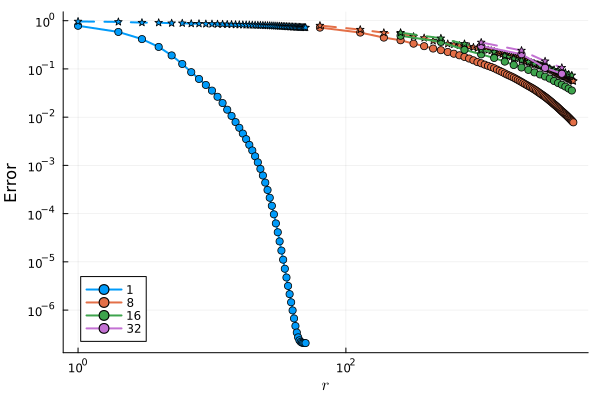

In [809]:
all_keys = keys(local_errors_training)
Is = sort([i[1] for i in all_keys])
Js = reverse(sort([i[2] for i in all_keys]))
rs = collect(1:size(local_errors_training[(Is[1],Js[1])])[1])
plot(xscale = :log10,yscale = :log10)
#plot()
for i in 1:size(Is)[1]
    I = Is[i]
    J = Js[i]
    qs = collect(1:size(local_errors_training[(I,J)])[1])
    plot!(I^2 .* qs,local_errors_training[(Is[i],Js[i])],color = i,label = I,linewidth = 2,marker = true)
    plot!(I^2 .* qs,local_errors_validation[(Is[i],Js[i])],color = i,label = false,linestyle = :dash,linewidth = 2,marker = :star)

end
xlabel!(L"r")
ylabel!("Error")
plot!(legend = :bottomleft)

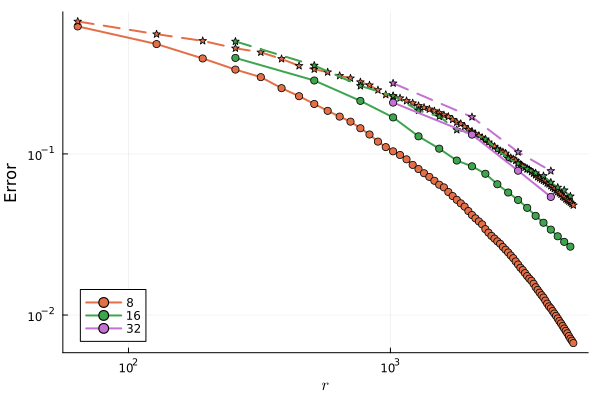

In [810]:
all_keys = keys(local_errors_training)
Is = sort([i[1] for i in all_keys])
Js = reverse(sort([i[2] for i in all_keys]))
rs = collect(1:size(overlap_errors_training[(Is[1],Js[1])])[1])
plot(xscale = :log10,yscale = :log10)
#plot()
for i in 2:size(Is)[1]
    I = Is[i]
    J = Js[i]
    qs = collect(1:size(local_errors_training[(I,J)])[1])
    plot!(I^2 .* qs,overlap_errors_training[(Is[i],Js[i])],color = i,label = I,linewidth = 2, marker = true)
    plot!(I^2 .* qs,overlap_errors_validation[(Is[i],Js[i])],color = i,label = false,linestyle = :dash,linewidth = 2, marker = :star)

end
xlabel!(L"r")
ylabel!("Error")
plot!(legend = :bottomleft)

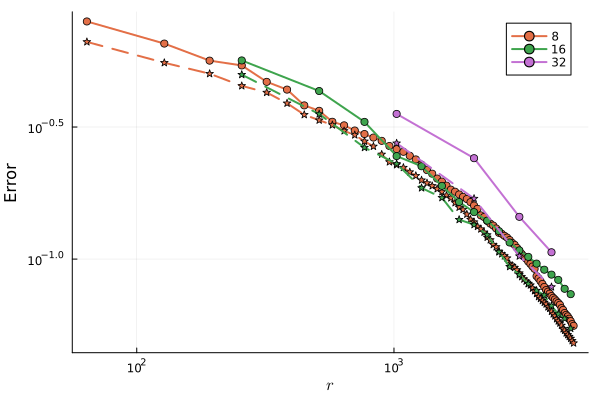

In [811]:
all_keys = keys(local_errors_training)
Is = sort([i[1] for i in all_keys])
Js = reverse(sort([i[2] for i in all_keys]))
rs = collect(1:size(overlap_errors_training[(Is[1],Js[1])])[1])
plot(xscale = :log10,yscale = :log10)
#plot()
for i in 2:size(Is)[1]
    I = Is[i]
    J = Js[i]
    qs = collect(1:size(local_errors_training[(I,J)])[1])
    plot!(I^2 .* qs,local_errors_validation[(Is[i],Js[i])],color = i,label = I,linewidth = 2, marker = true)
    plot!(I^2 .* qs,overlap_errors_validation[(Is[i],Js[i])],color = i,label = false,linestyle = :dash,linewidth = 2, marker = :star)

end
#hline!([0.005],label = false,linewidth = 2,color = :black)
xlabel!(L"r")
ylabel!("Error")
plot!()

# Implicit solver

In [836]:
q = 20
I = (16,16)
J = Int.(round.(fine_mesh.N ./I))
# compression in each direction
coarse_mesh = gen_coarse_from_fine_mesh(fine_mesh,J)
MP = gen_mesh_pair(fine_mesh,coarse_mesh)


modes,S = carry_out_local_SVD(training_data,MP)
overlap_modes,overlap_S,overlap_MP = carry_out_local_SVD_overlap_2D_periodic_only(training_data,MP)

prod(MP.coarse_mesh.N) * q


5120

In [837]:
local_PO = gen_projection_operators(modes[:,:,:,1:q],MP)
overlap_PO = gen_projection_operators_overlap_2D_periodic_only(overlap_modes[:,:,:,1:q],overlap_MP)
0

0

In [838]:
compute_L2(local_PO.Phi(local_PO.Phi_T(validation_data)), validation_data)

0.07110748380930829

In [839]:
compute_L2(overlap_PO.Phi(overlap_PO.S_inv(overlap_PO.Phi_T(validation_data))), validation_data)

0.05313746321066361

In [840]:
local_proj_FOM(a,PO = local_PO,rhs = rhs,fine_mesh = fine_mesh) = proj_FOM(a,PO,rhs,fine_mesh)
overlap_proj_FOM(a,PO = overlap_PO,rhs = rhs,fine_mesh = fine_mesh) = proj_FOM(a,PO,rhs,fine_mesh)
0

0

In [841]:
sp_S = sparsify_matrix(overlap_PO.S)


5120×5120 SparseMatrixCSC{Float64, Int64} with 919040 stored entries:
⎡⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎤
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎣⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎦

In [842]:
local_a0 = local_PO.Phi_T(c0)[1:end]
overlap_a0 = overlap_PO.S_inv(overlap_PO.Phi_T(c0))[1:end]

local_A = sparsify_matrix(Matrix(generate_ROM_operator(size(local_a0),local_proj_FOM)))
overlap_A =  sparsify_matrix(generate_ROM_operator(size(overlap_a0),overlap_proj_FOM))
0

LoadError: InterruptException:

In [843]:
local_rhs(a,mesh,t;A = local_A,other_arguments = 0) = A * a
overlap_rhs(a,mesh,t,A = overlap_A, S = lu(sp_S);other_arguments = 0) = S \ (A * a)



overlap_rhs (generic function with 3 methods)

In [844]:
overlap_dt = 0.2

B = (sp_S - overlap_dt/2 * overlap_A)
C = (sp_S + overlap_dt/2 * overlap_A)

B = lu(B)

function overlap_CN_step(input,mesh,t,dt,rhs;B = B,C = C,other_arguments = 0)
    return B \ (C * input)
end

LoadError: DimensionMismatch: argument shapes must match

In [845]:
t,  local_res = simulate(local_a0,coarse_mesh,0.025,0,5,local_rhs,save_every = 4)
local_res[end]

Progress:  37%|███████████████▏                         |  ETA: 0:00:01

LoadError: InterruptException:

In [846]:
t,  overlap_res = simulate(overlap_a0,coarse_mesh,overlap_dt,0,5,overlap_rhs,time_step_function = overlap_CN_step,save_every = 1)

LoadError: DimensionMismatch: second dimension of A, 2560, does not match the first dimension of B, 5120

In [847]:
local_q_r = local_PO.Phi(reshape(local_res,(coarse_mesh.N...,q,size(local_res)[end])))

overlap_shape = ((Int.(round.(coarse_mesh.N) ./ 2))...,4*q,size(overlap_res)[end]) 
overlap_q_r = overlap_PO.Phi(reshape(overlap_res,overlap_shape))

LoadError: DimensionMismatch: new dimensions (16, 16, 20, 50) must be consistent with array size 128000

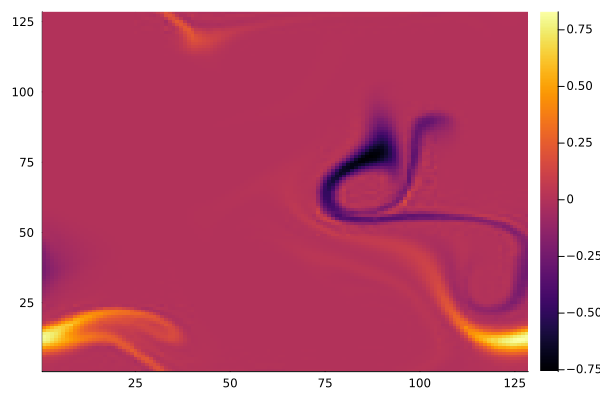

In [848]:
heatmap(local_PO.Phi(local_PO.Phi_T(training_data))[:,:,1,end])

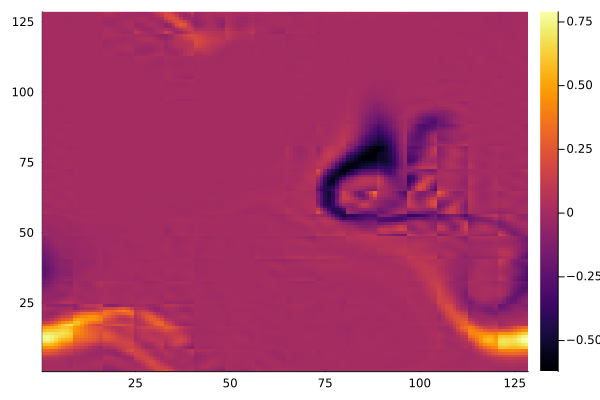

In [849]:
heatmap(local_q_r[:,:,1,end])

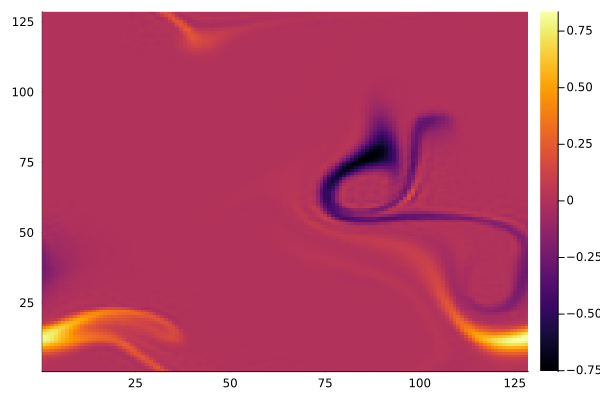

In [850]:
heatmap(overlap_PO.Phi(overlap_PO.S_inv(overlap_PO.Phi_T(training_data)))[:,:,1,end])

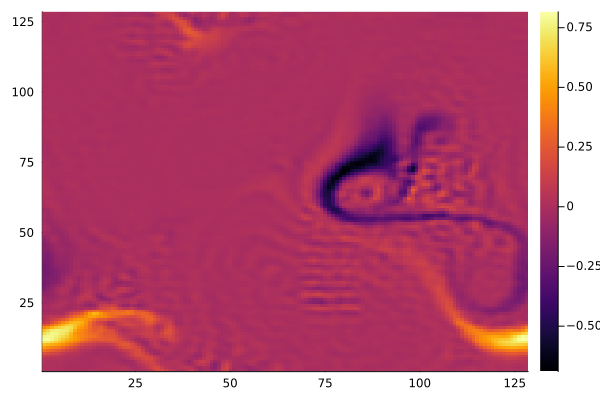

In [851]:
heatmap(overlap_q_r[:,:,1,end])

[ Info: Saved animation to /home/toby/Projects/local_POD_overlap.jl/DNS_flow.gif


Plots.AnimatedGif("/home/toby/Projects/local_POD_overlap.jl/DNS_flow.gif")
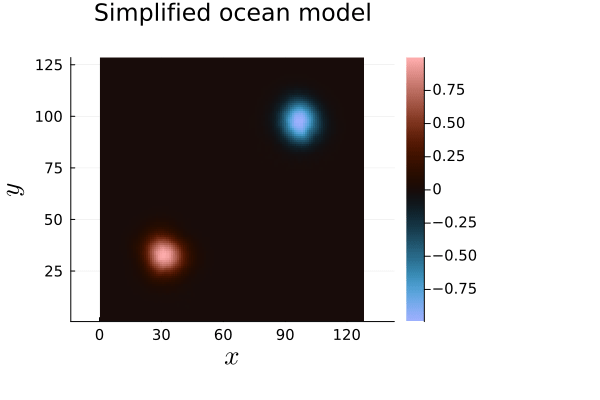

In [828]:
to_plot = overlap_q_r[:,:,1,:]
#to_plot = setup_bar.O.w(pred_sim[:,:,1:2,:])[:,:,1,:]

ymin = minimum(to_plot)
ymax = maximum(to_plot)


anim = @animate for index in 1:size(to_plot)[3]
    Plots.heatmap(to_plot[:,:,index]',color = :berlin,yflip=false,xtickfontsize = 10,ytickfontsize = 10
    ,aspect_ratio = :equal,titlefontsize=16,yguidefontsize=18,xguidefontsize=18,title = "Simplified ocean model",right_margin = 35Plots.mm)
    Plots.xlabel!(L"x")
    Plots.ylabel!(L"y")
    #title!(L"t = " * string(round(example_t[index],digits = 1)))
end

gif(anim, "DNS_flow.gif", fps = 30)

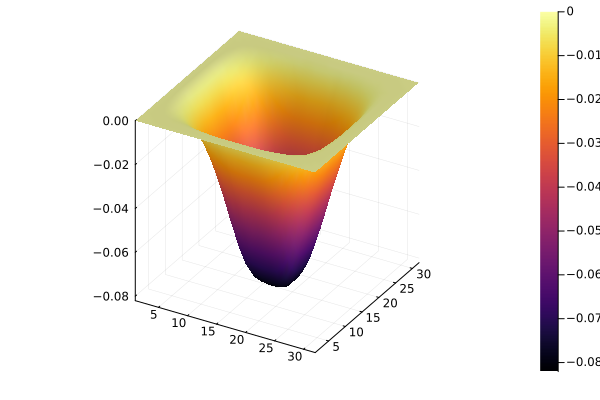

In [625]:
surface(overlap_modes[:,:,1,1])

# Experiment with the timestep

In [526]:
dts = collect(0.01:0.01:0.2)



20-element Vector{Float64}:
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 0.1
 0.11
 0.12
 0.13
 0.14
 0.15
 0.16
 0.17
 0.18
 0.19
 0.2